<a href="https://colab.research.google.com/github/Simaniyeva/News_Classification_NLP/blob/main/Azerbaijan_News_Classification_NLP_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Azerbaijan News Classification - NLP Competition**



# **Introduction**

The notebook structure consists of the following sections:
1. Introduction
 * 1.1 Structure
 * 1.2 Introduction
 * 1.3 Importing Libraries
2. Data Analysis and Preparation
3. Feature Engineering
4. Testing Different Models
5. Model Evaluation

**Introduction**
The main goal of this project is to classify news articles in Azerbaijani using artificial intelligence methods. Within the framework of the project, various **classification models** will be tested and an attempt will be made to achieve the highest **F1-score**.


According to the terms of the competition:
* **F1-score** is the main evaluation criterion.

* The use of external data is prohibited.

* Only **pre-existing pre-trained models** can be used.

* **The code must be run in a notebook and the result must be submitted in the submission.csv format.**


This project will be an important step for the development of **NLP applications in Azerbaijani**.



# Data Analysis and Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import shutil
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy kaggle.json from Google Drive
shutil.copy('/content/drive/MyDrive/Kaggle/kaggle.json', '/root/.kaggle/kaggle.json')

# Set correct permissions
os.chmod('/root/.kaggle/kaggle.json', 600)


In [4]:
!kaggle competitions download -c ufaz-news-classifier-challenge -p /content/drive/MyDrive/Kaggle


ufaz-news-classifier-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


**Importing Libraries**

In [80]:
# It is used for text processing (re, string) and data visualization (seaborn, matplotlib).
import re,string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score

# NLTK used for natural language tokenization, lemmatization, and stopword cleaning.
import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Model Preparation and Transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

#  Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Model Building and Evaluation

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from tabulate import tabulate

# Imbalanced Learn
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/Kaggle/ufaz-news-data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Kaggle/ufaz-news-data/test.csv')
df_train.head()

,id,text,category
0,0,"Ukrayna dalanda, Qərblə Rusiya sövdələşmə həvə...",siyaset
1,1,Aktyor Nurlan Rüstəmov: “Bizə lal-kar deyilməs...,medeniyyet
2,2,Azərbaycana turist axını: Rusiyalı səyyahların...,turizm
3,3,Heydər Əliyev Sarayına yeni direktor təyin olu...,cemiyyet
4,4,"Türkiyəli mütəxəssisdən açıqlama: ""Həddindən a...",dunya


**Exploratory Data Analysis**

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11919 entries, 0 to 11918
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11919 non-null  int64 
 1   text      11919 non-null  object
 2   category  11919 non-null  object
dtypes: int64(1), object(2)
memory usage: 279.5+ KB


In [8]:
df_train.isnull().sum()

,0
id,0
text,0
category,0


It appears that there are no missing values ​​in the data, with 0 missing values ​​in each column. This is a good indicator and there is no need to do any cleaning or changes to the data to proceed to the next steps.

In [9]:
df_train['category'].value_counts()

,count
category,
dunya,1836
siyaset,1640
cemiyyet,1563
digar,1314
kriminal,1124
turizm,930
iqtisadiyyat,681
ordu,611
medeniyyet,519


This result indicates that some categories are overrepresented in the data, meaning that the data is unbalanced. For example, the category "world" occurs 1836 times, but "cinemastercard" occurs only 85 times. This imbalance will increase the likelihood that the model will learn better against certain classes, and can sometimes lead to poor performance for underrepresented categories.

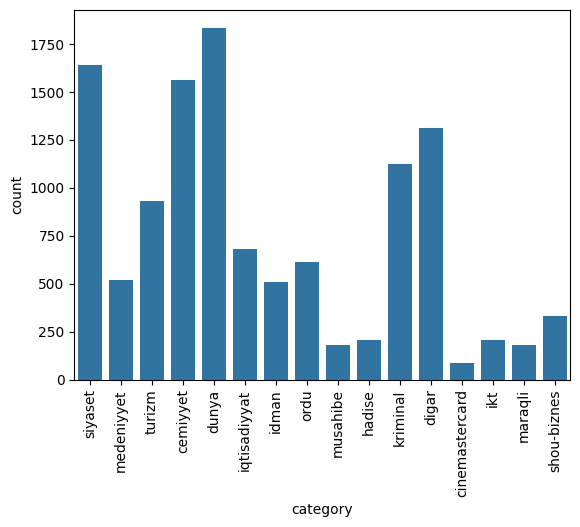

In [10]:
sns.countplot(x='category', data=df_train)
plt.xticks(rotation=90)
plt.show()

In [11]:
df_train.drop('id',axis=1,inplace=True)

In [12]:
df_train.head()

,text,category
0,"Ukrayna dalanda, Qərblə Rusiya sövdələşmə həvə...",siyaset
1,Aktyor Nurlan Rüstəmov: “Bizə lal-kar deyilməs...,medeniyyet
2,Azərbaycana turist axını: Rusiyalı səyyahların...,turizm
3,Heydər Əliyev Sarayına yeni direktor təyin olu...,cemiyyet
4,"Türkiyəli mütəxəssisdən açıqlama: ""Həddindən a...",dunya


In [13]:
df_train['text_length']=df_train['text'].apply(len)
df_train['text_length'].describe()

,text_length
count,11919.000000
mean,1950.172246
std,2430.967465
min,145.000000
25%,749.000000
50%,1157.000000
75%,2072.500000
max,46799.000000


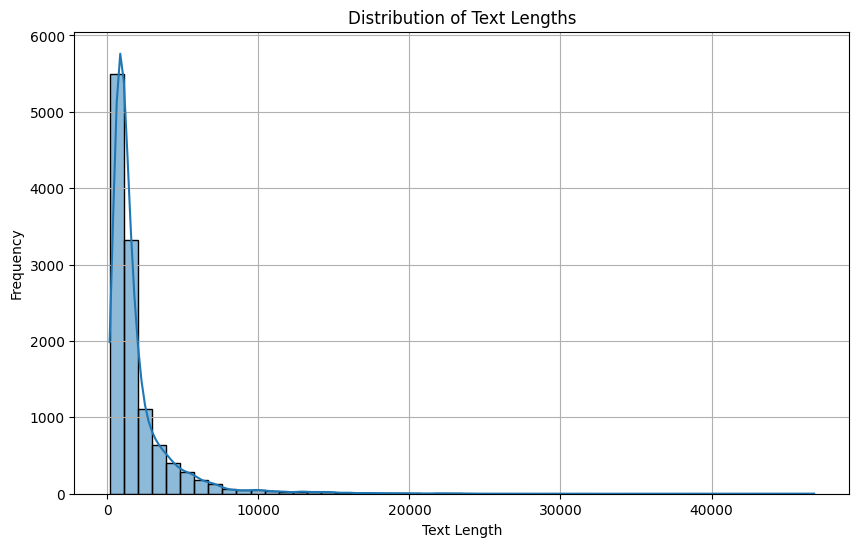

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
grouped = df_train.groupby('category')['text_length']
median_length = grouped.median().reset_index(name='median_text_length')
average_length = grouped.mean().reset_index(name='average_text_length')
merged_df = pd.merge(median_length, average_length, on='category')
merged_df

,category,median_text_length,average_text_length
0,cemiyyet,1130.0,2187.658349
1,cinemastercard,1301.0,1424.917647
2,digar,1837.5,2184.981735
3,dunya,847.0,1097.746732
4,hadise,823.5,1032.601942
5,idman,947.0,2706.155512
6,ikt,1067.0,1355.961538
7,iqtisadiyyat,1377.0,2195.604993
8,kriminal,1158.0,1634.968861
9,maraqli,1062.0,1404.906077


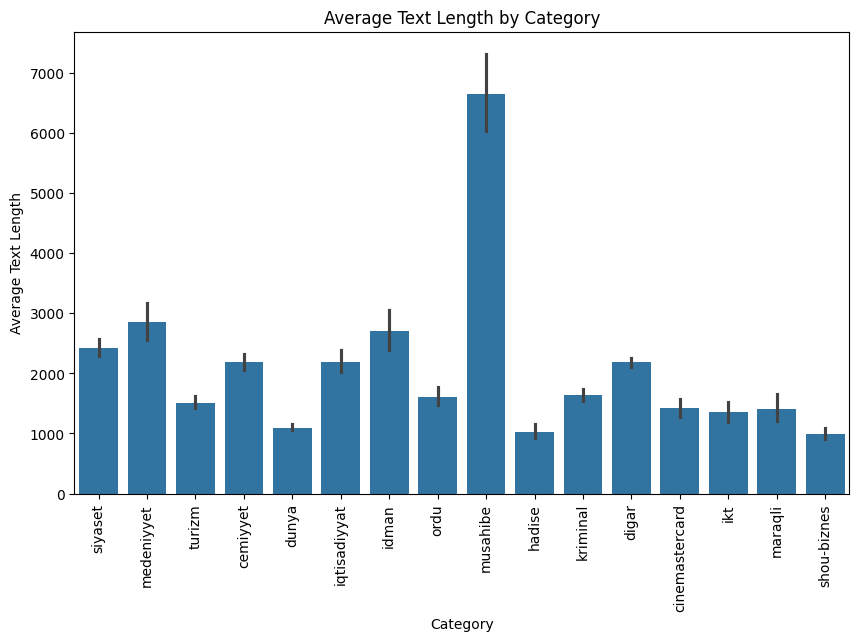

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='text_length', data=df_train)
plt.xticks(rotation=90)
plt.title('Average Text Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Text Length')
plt.show()

'musahibe' contain more text because they consist of a few questions and answers. In other news categories ("show business"), the information can be shorter and more specific.

In [17]:
df_train['text']=df_train['text'].apply(word_tokenize)


# Feature Engineering

In [92]:
df_train

,text,category,text_length
0,ukrayna dalanda qərblə rusiya sövdələşmə həvəs...,14,2630
1,aktyor nurlan rüstəmov bizə lal kar deyilməsi ...,10,6860
2,azərbaycana turist axını rusiyalı səyyahların ...,15,508
3,heydər əliyev sarayına yeni direktor təyin olu...,0,820
4,türkiyəli mütəxəssisdən açıqlama həddindən gər...,3,1611
...,...,...,...
11914,azərbaycanın beynəlxalq mövqeyi necə gücləndi ...,14,2426
11915,i ran suriya üzrə xüsusi nümayəndə təyin edib ...,3,292
11916,donald tramp məşhur aktyoru xüsusi səfir təyin...,3,533
11917,yazıçı vaqif əlixanlı vəfat edib yazıçı dramat...,10,1327


The data shows an unbalanced distribution in the `category` column. This imbalance may cause the model to learn some classes less.

In [19]:
from nltk.corpus import stopwords
stopwords.words('azerbaijani')

['a',
 'ad',
 'altı',
 'altmış',
 'amma',
 'arasında',
 'artıq',
 'ay',
 'az',
 'bax',
 'belə',
 'bəli',
 'bəlkə',
 'beş',
 'bəy',
 'bəzən',
 'bəzi',
 'bilər',
 'bir',
 'biraz',
 'biri',
 'birşey',
 'biz',
 'bizim',
 'bizlər',
 'bu',
 'buna',
 'bundan',
 'bunların',
 'bunu',
 'bunun',
 'buradan',
 'bütün',
 'ci',
 'cı',
 'çox',
 'cu',
 'cü',
 'çünki',
 'da',
 'daha',
 'də',
 'dedi',
 'dək',
 'dən',
 'dəqiqə',
 'deyil',
 'dir',
 'doqquz',
 'doqsan',
 'dörd',
 'düz',
 'ə',
 'edən',
 'edir',
 'əgər',
 'əlbəttə',
 'elə',
 'əlli',
 'ən',
 'əslində',
 'et',
 'etdi',
 'etmə',
 'etmək',
 'faiz',
 'gilə',
 'görə',
 'ha',
 'haqqında',
 'harada',
 'hə',
 'heç',
 'həm',
 'həmin',
 'həmişə',
 'hər',
 'ı',
 'idi',
 'iki',
 'il',
 'ildə',
 'ilə',
 'ilk',
 'in',
 'indi',
 'isə',
 'istifadə',
 'iyirmi',
 'ki',
 'kim',
 'kimə',
 'kimi',
 'lakin',
 'lap',
 'məhz',
 'mən',
 'mənə',
 'mirşey',
 'nə',
 'nəhayət',
 'niyə',
 'o',
 'obirisi',
 'of',
 'olan',
 'olar',
 'olaraq',
 'oldu',
 'olduğu',
 'olmadı',
 

In [20]:
def preprocess(text):
  text=str(text).lower().strip()
  text=re.sub('<.*?>','',text)
  text = re.sub(r'[^\w\söğıçşüÖĞİÇŞÜƏə]', ' ', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def remove_stopword(string):
  str=[word for word in string.split() if word not in stopwords.words('azerbaijani')]
  return ' '.join(str)

In [21]:
df_train['text']=df_train['text'].apply(preprocess)
df_train['text']=df_train['text'].apply(remove_stopword)

In [22]:
df_train['text'][5]

'hesablama palatası socar gələn milyon manat dividend ödəməli olacaq azərbaycanda dövlət müəssisələrinin dividend ödənişləri üzrə proqnozun artırılmasının səbəbi məlum olub report xəbər verir barədə hesablama palatasının dövlət büdcəsi qanun layihəsinə verdiyi rəydə bildirilir sənədə əsasən artım dövlət neft şirkətinin socar dividend ödənişi üzrə proqnozun milyon manat yaxud artırılaraq milyon manata çatdırılması bağlıdır'

In [23]:
lemmatizer=WordNetLemmatizer()
df_train['text']=df_train['text'].apply(lemmatizer.lemmatize)

In [24]:
df_train['text'][5]

'hesablama palatası socar gələn milyon manat dividend ödəməli olacaq azərbaycanda dövlət müəssisələrinin dividend ödənişləri üzrə proqnozun artırılmasının səbəbi məlum olub report xəbər verir barədə hesablama palatasının dövlət büdcəsi qanun layihəsinə verdiyi rəydə bildirilir sənədə əsasən artım dövlət neft şirkətinin socar dividend ödənişi üzrə proqnozun milyon manat yaxud artırılaraq milyon manata çatdırılması bağlıdır'

In [25]:
le=LabelEncoder()
le.fit(df_train['category'])
df_train['category']=le.transform(df_train['category'])

In [26]:
df_train.category.unique()

array([14, 10, 15,  0,  3,  7,  5, 12, 11,  4,  8,  2,  1,  6,  9, 13])

**Encoding (TF-IDF (Term Frequency-Inverse Document Frequency))**


The text data was first converted into a numerical form so that it could be processed by the model. For this, `TF-IDF (Term Frequency-Inverse Document Frequency)` vectorization was used. This method calculates the importance of each word based on its frequency within the document and in the overall corpus.

This encoding method led to more stable and balanced results, especially in SVM and Logistic Regression models.

In [27]:
tfidf=TfidfVectorizer(min_df=3,
                      max_df=0.8,
                      max_features=10000,
                      token_pattern=r'\b[a-zöğıçşüəÖĞİÇŞÜƏ]{4,15}\b',
                      )
tfidf_matrix = tfidf.fit_transform(df_train['text'])

In [28]:
feature_names = tfidf.get_feature_names_out()
print(feature_names[:20])


['abadlıq' 'abbas' 'abbasov' 'abbasovun' 'abdulla' 'abdullah' 'abdullayev'
 'abdullayeva' 'abdullayevin' 'abidə' 'abidələr' 'abidələri' 'abidələrin'
 'abidənin' 'abidəsi' 'abunəçiləri' 'abunəçiyə' 'abşeron' 'abşeronda'
 'academy']


In [29]:
X_train,X_test,y_train,y_test=train_test_split(tfidf_matrix,
                                               df_train['category'],
                                               test_size=0.2,
                                               shuffle=True,
                                               stratify=df_train['category'],
                                               random_state=42)

Some categories in our dataset have more examples than others. This can cause the model to prefer learning those classes with more examples.

SMOTE (Synthetic Minority Over-sampling Technique) helps balance the dataset by augmenting classes with fewer examples with artificial examples. This technique is applied to the training data and ensures that the model learns in a more objective and balanced way.

In this project, `SMOTE` was used to balance `X_train` and `y_train`, and then models were trained with this data.

In [30]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In this step, we split the data into two parts for training and testing the model: 80% for training; 20% for testing

This allows us to test how the model applies what it has learned to data it has not seen before.

**`shuffle=True `**shuffles the data randomly so that the order does not affect the result.

**`random_state=42`** provides a constant seed to get the same result when running it again.

In [31]:
X_train.shape

(9535, 10000)

In [32]:
X_test.shape

(2384, 10000)

# Testing Different Models

# K Nearest Neighbors (KNN) model
At this stage, the K Nearest Neighbors (KNN) model was applied with the One-vs-Rest strategy. This strategy separates each class from the other classes, transforming the multi-class problem into a series of two-class models.



In [82]:
knn_model=OneVsRestClassifier(KNeighborsClassifier())
knn_model.fit(X_train,y_train)
knn_predictions=knn_model.predict(X_test)
f1_score_knn=f1_score(y_test, knn_predictions, average='weighted')
accuracy_knn=accuracy_score(y_test,knn_predictions)
print("KNN Model Accuracy:",accuracy_knn)
print("F1-score:",f1_score_knn )

KNN Model Accuracy: 0.6552013422818792
F1-score: 0.6442435094724237


The accuracy of the model on the test data was: ~66%. This result is somewhat satisfactory, but should be compared with other models.

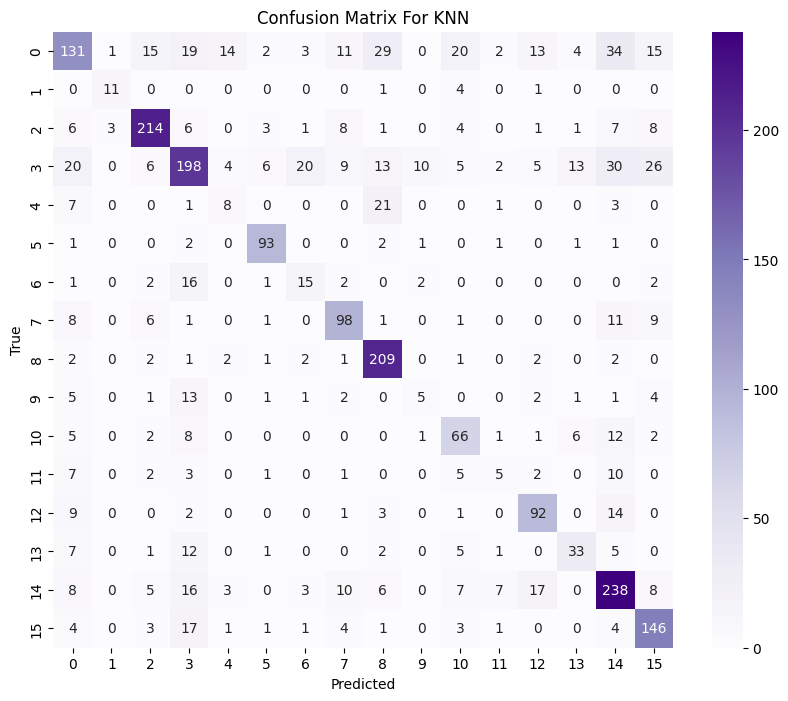

In [37]:
cm = confusion_matrix(y_test, knn_predictions, labels=knn_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=knn_model.classes_,
            yticklabels=knn_model.classes_,
            cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix For KNN')
plt.show()


The resulting confusion matrix is ​​displayed visually and analyzed to determine which classes the model performs best.

These results allow for in-depth analysis of the model's overall performance and errors.

# The Logistic Regression model
Logistic Regression model is one of the most widely used models in text-based multiclass classification problems. In this model, the convergence of the model was ensured by setting `max_iter=1000`.

After the model was trained on the training data, it was tested on the test data and the `accuracy` value was obtained. The performance of the model was evaluated for each class using the confusion matrix.

Logistic Regression performs particularly well on **TF-IDF represented text data** and is a balanced choice in many cases in terms of simplicity and performance.

In [83]:
lr_model = LogisticRegression(max_iter=1000,class_weight='balanced',penalty='l2')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, lr_predictions)
f1_score_lr=f1_score(y_test, lr_predictions, average='weighted')
print("Logistic Regression Accuracy:", accuracy_lr)
print("F1-score:",f1_score_lr)

Logistic Regression Accuracy: 0.7143456375838926
F1-score: 0.7183625487137629


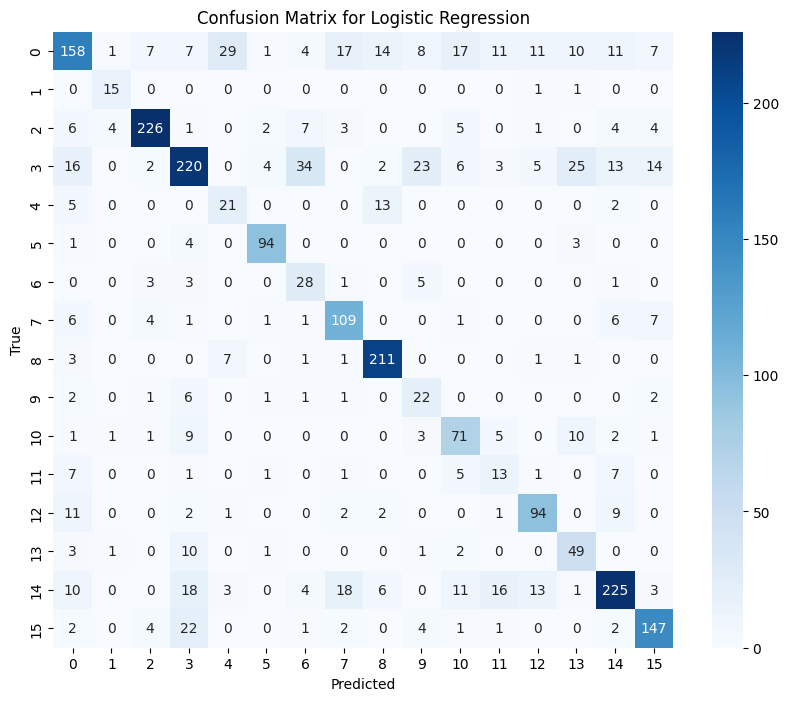

In [40]:
# Confusion matrix
cm = confusion_matrix(y_test, lr_predictions, labels=lr_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


# Multinomial Naive Bayes
At this stage, the Multinomial Naive Bayes model was used. This model is one of the models that is particularly suitable for text classification and can provide efficient results when combined with TfidfVectorizer.

In [84]:
model=MultinomialNB()
model.fit(X_train,y_train)
labels=model.predict(X_test)
f1_score_nv=f1_score(y_test, labels, average='weighted')
accuracy_nv=accuracy_score(y_test,labels)
print("Multinomial Naive Bayes Accuracy:", accuracy_nv)
print("F1-score:",f1_score_nv)

Multinomial Naive Bayes Accuracy: 0.6984060402684564
F1-score: 0.6630718417209249


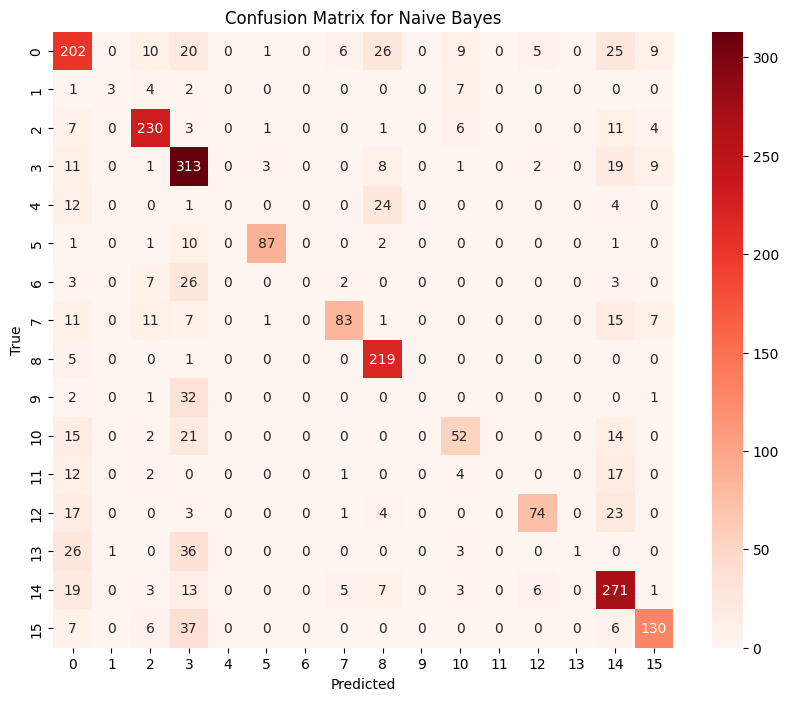

In [59]:
# Confusion matrix
cm = confusion_matrix(y_test, labels, labels=model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=model.classes_,
            yticklabels=model.classes_,
            cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

In [60]:
kappa = cohen_kappa_score(y_test, labels)
print(f"Cohen's Kappa: {kappa}")


Cohen's Kappa: 0.6596046193474743


# LinearSVC (Support Vector Classifier)
LinearSVC (Support Vector Classifier) ​​is a linear variant of the Support Vector Machine (SVM) method. The goal is to find the best line that separates different classes in the data. The LinearSVC model works with linear decision boundaries, especially on the training data, and therefore can achieve faster results on large data sets.

In [85]:
svc_model=LinearSVC()
svc_model.fit(X_train,y_train)
svc_predictions=svc_model.predict(X_test)
f1_score_svc=f1_score(y_test, svc_predictions, average='weighted')
accuracy_svc=accuracy_score(y_test,svc_predictions)
print("SVC Accuracy:",accuracy_svc )
print("F1-score:",f1_score_svc)

SVC Accuracy: 0.7495805369127517
F1-score: 0.7400248090991387


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svc_predictions))


              precision    recall  f1-score   support

           0       0.63      0.67      0.65       313
           1       0.81      0.76      0.79        17
           2       0.92      0.89      0.90       263
           3       0.68      0.81      0.74       367
           4       0.50      0.17      0.25        41
           5       0.86      0.90      0.88       102
           6       0.44      0.27      0.33        41
           7       0.78      0.77      0.77       136
           8       0.85      0.96      0.90       225
           9       0.50      0.19      0.28        36
          10       0.65      0.64      0.65       104
          11       0.45      0.14      0.21        36
          12       0.80      0.72      0.76       122
          13       0.73      0.61      0.67        67
          14       0.76      0.76      0.76       328
          15       0.78      0.77      0.78       186

    accuracy                           0.75      2384
   macro avg       0.70   

# Presentation of Results

The model results were evaluated with a confusion matrix, classification report, and individual test cases.

In addition, a comparison between the models was shown with a pandas table and a submission.csv was created based on the prediction of the model that gave the highest result.

The file was prepared according to the competition format (id, category) and made ready for submission.

In [88]:
import pandas as pd

models = ["KNN", "Logistic Regression",'Naive Bayes', "SVC"]
f1_scores = [f1_score_knn, f1_score_lr, f1_score_nv, f1_score_svc]
accuracy = [accuracy_knn, accuracy_lr, accuracy_nv, accuracy_svc]

comparison_df = pd.DataFrame({
    'Model': models,
    'F1_Score': f1_scores,
    'Accuracy': accuracy
})

comparison_df = comparison_df.sort_values(by='F1_Score', ascending=False)

print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))


| Model               |   F1_Score |   Accuracy |
|:--------------------|-----------:|-----------:|
| SVC                 |   0.740025 |   0.749581 |
| Logistic Regression |   0.718363 |   0.714346 |
| Naive Bayes         |   0.663072 |   0.698406 |
| KNN                 |   0.644244 |   0.655201 |


I chose the SVC model because it gave the highest result – I got an F1-score of 0.74. This shows that the model has a good ability to classify the data and gives correct results. SVC works well for linearly separable data and defines the boundaries between different classes well.

In [91]:
X_test_tfidf = tfidf.transform(df_test['text'])
preds = svc_model.predict(X_test_tfidf)
pred_labels = le.inverse_transform(preds)
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'category': pred_labels
})
submission_df.to_csv("submission.csv", index=False)